# Reweighting inputs for the $m_{hh}$ trainings

**Goal:** We were interested in *what region* was driving the $m_{hh}$ limits, so to we tried training with some $m_{hh}$ cuts to see *what the impact* was on the SM limit and the associated systematic for whether of not these *low mass* events were included.

In [83]:
import pandas as pd
import numpy as np
from itertools import product
from glob import glob
import uproot
import pyhf

import os
os.sys.path += ['../RRevolution/code','../code', "../eda_tools/", "../PyATLASstyle/"]
from analysis import getXhh
from utils import L
from eventDisplays import rainbow_text
from utilities import weighted_chisquare

import matplotlib.pyplot as plt
from matplotlib import gridspec

import logging   
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)
        
plt.rcParams.update({'figure.max_open_warning': 0})

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [8]:
yr = 17

In [9]:
fDir = '/u/ki/nhartman/gpfs/diHiggs4b/data/RR/nom_trigs_unblind'

f = uproot.open(f'{fDir}/ntag_4b/data{yr}_min_dR_VEC_sr_124_117_NN_100_bootstraps.root') 
f_gt = uproot.open(f'{fDir}/data{yr}_min_dR_VEC_sr_124_117_NN_100_bootstraps_m_hh_gt_350.root') 
f_lt = uproot.open(f'{fDir}/data{yr}_min_dR_VEC_sr_124_117_NN_100_bootstraps_m_hh_lt_350.root')

In [19]:
rw_cols = ['njets','pT_4','pT_2','dRjj_1','dRjj_2','eta_i','pt_hh','X_wt_tag','m_hh',
           'HT', 'dPhi_h1', 'dPhi_h2', 'dRjj_h1', 'dRjj_h2','dR_hh']

load_cols = ['dEta_hh','phi_h1','phi_h2'] 
load_cols += [f'{v}_h{i}_j{j}' for v,i,j in product(['pT','eta','phi'],[1,2],[1,2])]

In [20]:
wcols = [f'NN_d24_weight_bstrap_med_{yr}',
         f'NN_d24_weight_VRderiv_bstrap_med_{yr}']

cols = ['ntag'] + rw_cols[:9] + load_cols+ wcols

Ok... cool! So what I did w/ these gt and lt dfs is just save the corresponding extra weights, since the nominal valules all stay the same.

In [51]:
sr    = f['sig'].pandas.df(cols)
sr_gt = f_gt['sig'].pandas.df(wcols)
sr_lt = f_lt['sig'].pandas.df(wcols)

vr    = f['validation'].pandas.df(cols)
vr_gt = f_gt['validation'].pandas.df(wcols)
vr_lt = f_lt['validation'].pandas.df(wcols)

cr    = f['control'].pandas.df(cols)
cr_gt = f_gt['control'].pandas.df(wcols)
cr_lt = f_lt['control'].pandas.df(wcols)

In [52]:
w_CR, w_VR = wcols

nCR_str = f'NN_norm_bstrap_med_{yr}'
nVR_str = f'NN_norm_VRderiv_bstrap_med_{yr}'

In [53]:
for df,df_gt,df_lt in zip([sr,vr,cr],[sr_gt,vr_gt,cr_gt],[sr_lt,vr_lt,cr_lt]):
    
    # Calculate the extra columns
    df['HT'] = np.sum(df[[f'pT_h{i}_j{j}' for i,j in product([1,2],[1,2])]].values,axis=1)
    
    df['dPhi_hh'] = np.arccos(np.cos(df.phi_h1 - df.phi_h2))
    df['dPhi_h1'] = np.arccos(np.cos(df.phi_h1_j1 - df.phi_h1_j2))
    df['dPhi_h2'] = np.arccos(np.cos(df.phi_h2_j1 - df.phi_h2_j2))
    
    df['dR_hh'] = np.sqrt(df.dEta_hh**2+df.dPhi_hh**2)
    df['dRjj_h1'] = np.sqrt((df.eta_h1_j1-df.eta_h1_j2)**2+df.dPhi_h1**2)
    df['dRjj_h2'] = np.sqrt((df.eta_h2_j1-df.eta_h2_j2)**2+df.dPhi_h2**2)
    
    # Normalize the (appropritate) weights    
    df['w_2b'] = df[w_CR] * f[nCR_str]._fVal
    df_gt['w_2b'] = df_gt[w_CR] * f_gt[nCR_str]._fVal
    df_lt['w_2b'] = df_lt[w_CR] * f_lt[nCR_str]._fVal
    
    df['w_2b_VR'] = df[w_VR] * f[nVR_str]._fVal
    df_gt['w_2b_VR'] = df_gt[w_VR] * f_gt[nVR_str]._fVal
    df_lt['w_2b_VR'] = df_lt[w_VR] * f_lt[nVR_str]._fVal
    

In [60]:
nBins = [8]+[40]*14
myRanges = [(3.5,12.5),(40,200),(40,200),(0,2*np.pi),(0,2*np.pi),(0,2.5),(0,400),
            (1.5,10),(200,1200),(0,1000),(0,np.pi),(0,np.pi),(0,4),(0,4),(0,2*np.pi)]

**Next Q:** How does the difference in the 4b definition impact the agreement with the reweighting variables

In [56]:
text = "$\mathbf{ATLAS}$ Data"+f" 20{yr} Internal\n"
text += "min_dR, res buckets, SR (124,117)"

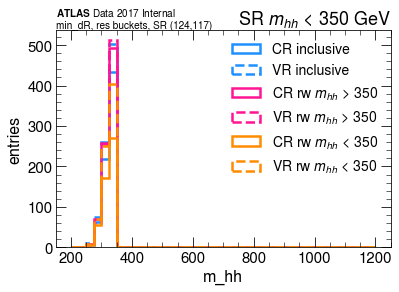

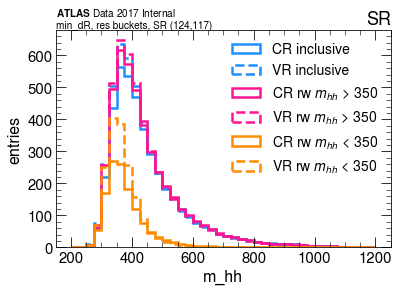

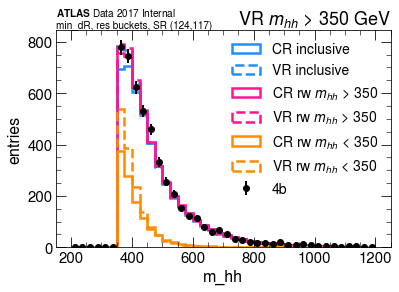

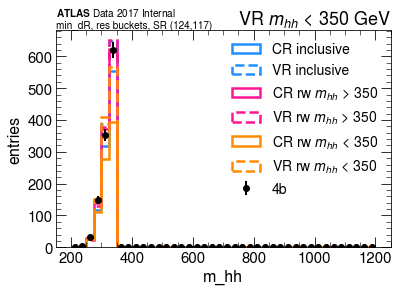

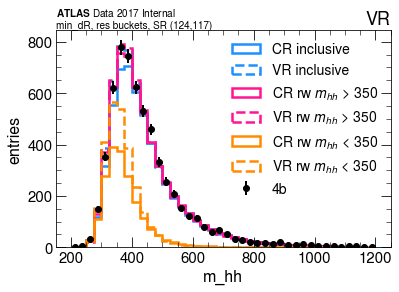

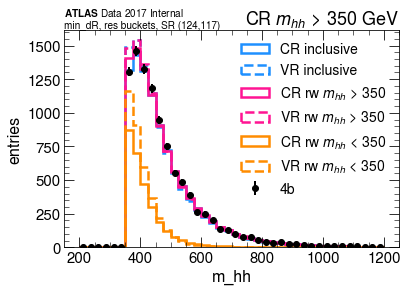

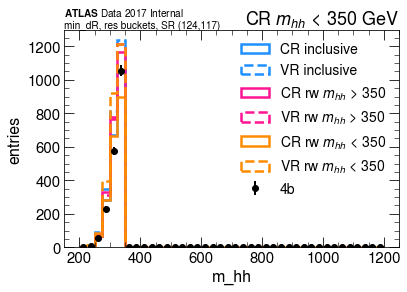

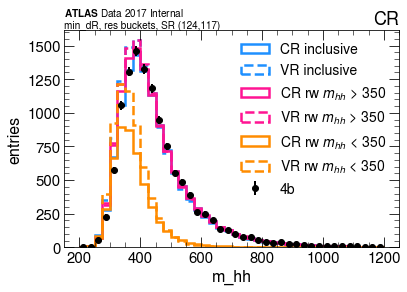

In [68]:
#figDir = f'figures/data17-JUN20/rw_evalAll'

for df,df_gt,df_lt,region in zip([sr,vr,cr],[sr_gt,vr_gt,cr_gt],[sr_lt,vr_lt,cr_lt],['SR','VR','CR']):

    for mi,ti,tag in zip([(df.m_hh > 350), (df.m_hh < 350), True],
                         [' $m_{hh}$ > 350 GeV',' $m_{hh}$ < 350 GeV',''],
                         ['_m_hh_gt_350','_m_hh_lt_350','']):
        
        
        
        figDir = f'figures/data{yr}-JUN20/rw_evalAll/'
        if tag: figDir += tag[1:]
        if not os.path.exists(figDir): os.mkdir(figDir)
        
        for c,n,r in zip(rw_cols,nBins,myRanges):

            #print(c)
            if c != 'm_hh': 
                continue
            else:

                        
            plt.figure()

            # 2b trainings
            for dfi,color,l in zip([df,df_gt,df_lt],['dodgerblue','deeppink','darkorange'],
                                   ['inclusive','rw $m_{hh}$ > 350','rw $m_{hh}$ < 350']):
                
                
                n_2b_CR = plt.hist(df.loc[mi & (df.ntag==2),c],n,r, label=f'CR {l}',
                                   histtype='step',lw=2.5,color=color,ls='-',
                                   weights=dfi.loc[mi & (df.ntag==2),'w_2b'])[0]
                n_2b_VR = plt.hist(df.loc[mi & (df.ntag==2),c],n,r, label=f'VR {l}',
                                   histtype='step',lw=2.5,color=color,ls='--',
                                   weights = dfi.loc[mi & (df.ntag==2),'w_2b_VR'])[0]
                
            # 4b  
            if region != 'SR':
                n_4b,e = np.histogram(df.loc[mi & (df.ntag>=4),c],n,r)
                
                xx = 0.5 * (e[1:]+e[:-1])
                plt.errorbar(xx, n_4b, np.sqrt(n_4b), color='k',label='4b',
                             marker='o',lw=0,elinewidth=2)

            plt.xlabel(c,fontsize=16)
            plt.ylabel('entries',fontsize=16)
            plt.legend(loc='best')

            ax = plt.gca()
            plt.title(f'{region}{ti}',loc='right')
            plt.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)
            
            ylim = plt.ylim()
            if 'HT' in c: plt.plot([300]*2,ylim,'k--')
            plt.ylim(ylim)   

            plt.savefig(f'{figDir}/{c}_{region}.pdf',bbox_inches='tight')

#             break
#         break
#     break

Cool - the above plots are *nice* for a qualitative assessment, but I think it might *also* be useful to just compare the inclusive vs exclusive for the dedicated regions they were trained for.

**Evaluating $m_{hh} > 350 GeV$**

In [84]:
chi2 = weighted_chisquare(n_2b_CR,n_2b_VR,err_CR,err_VR,stat_lim=5)[0] / n

../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (

../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (

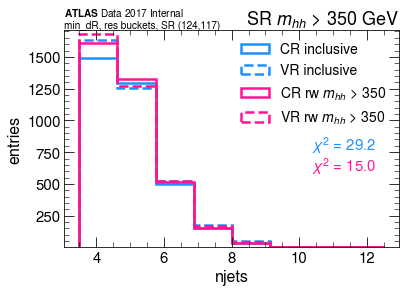

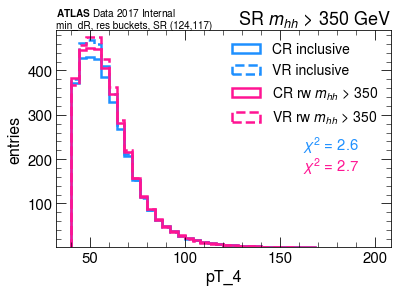

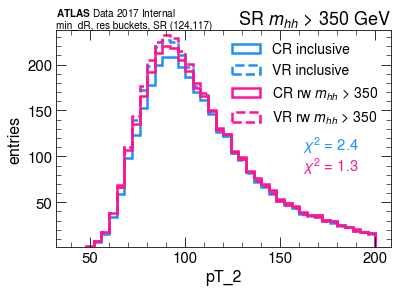

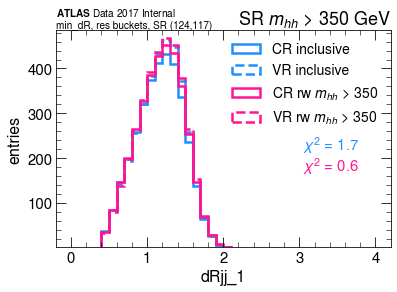

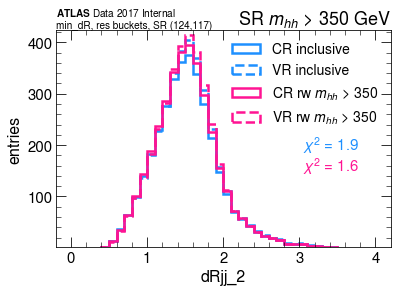

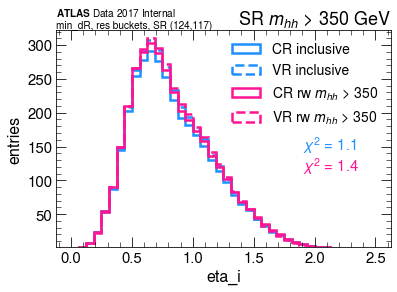

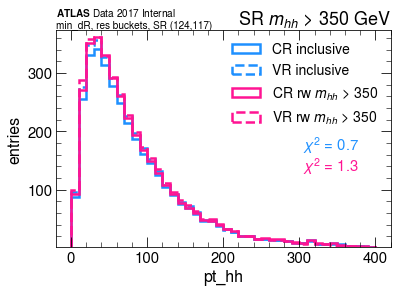

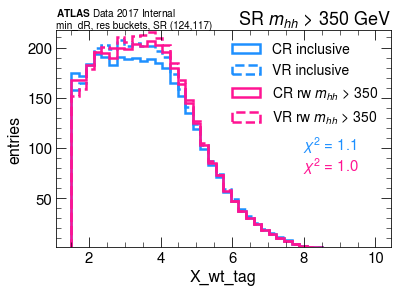

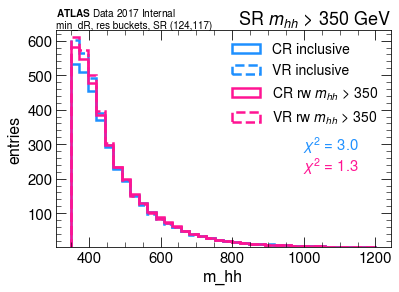

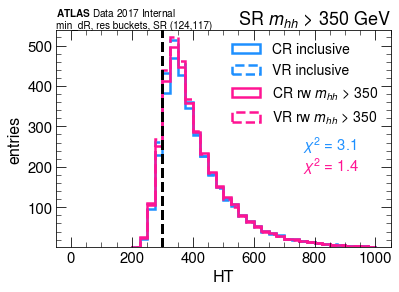

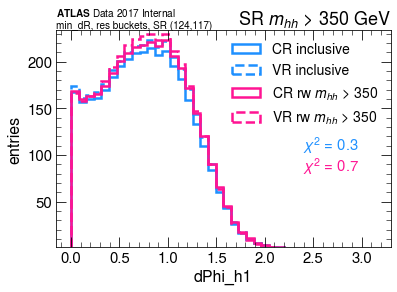

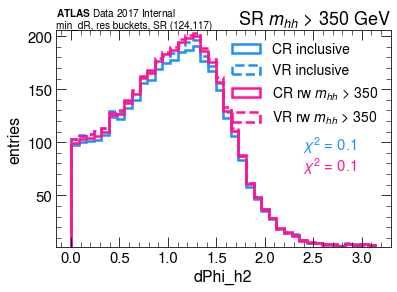

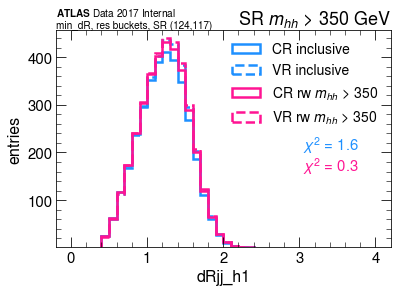

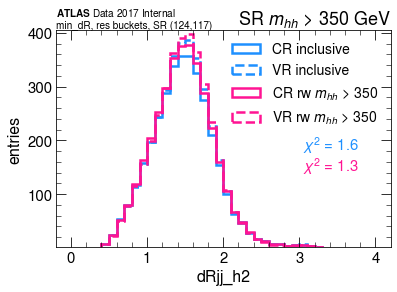

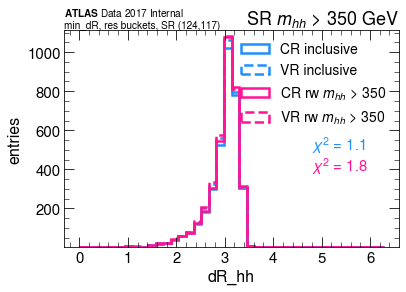

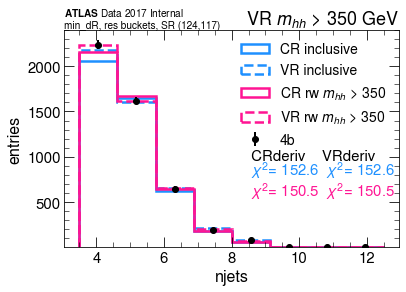

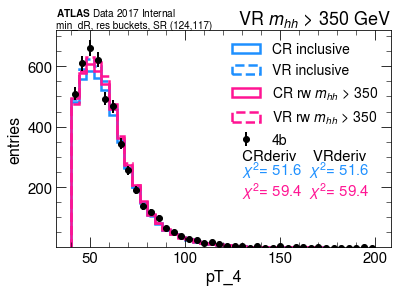

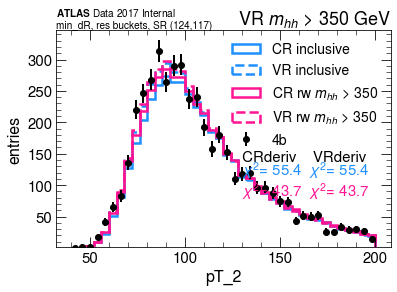

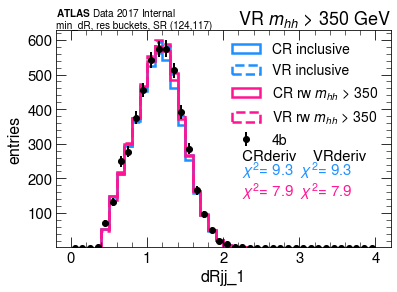

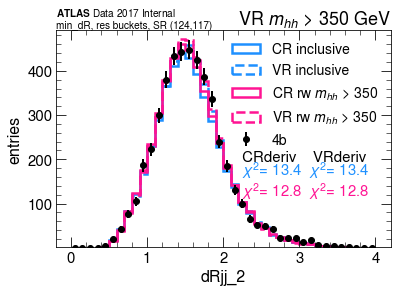

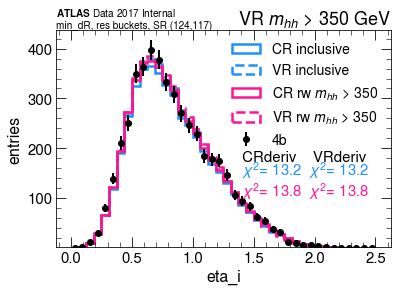

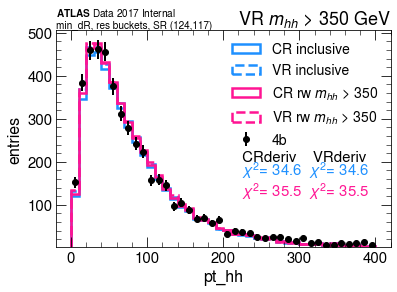

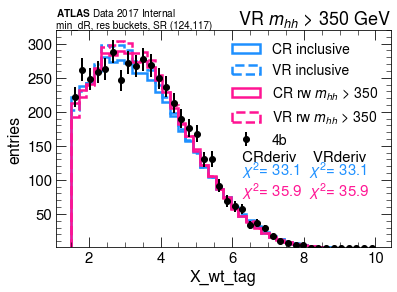

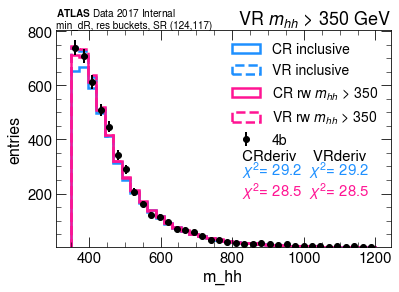

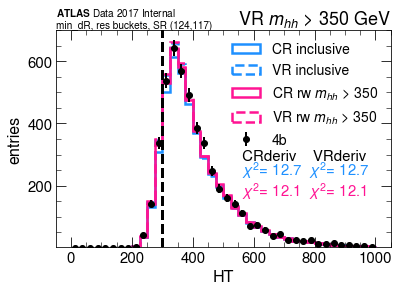

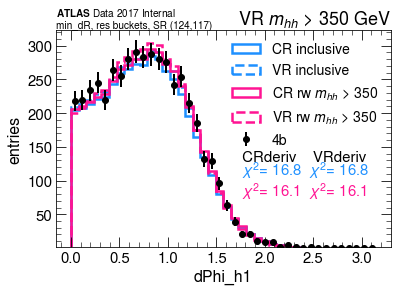

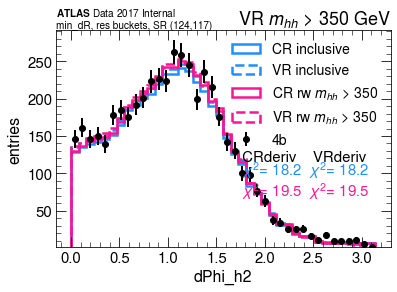

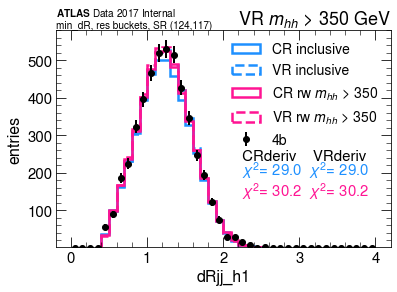

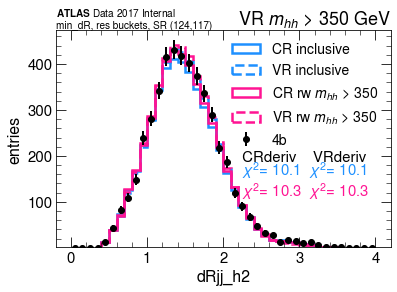

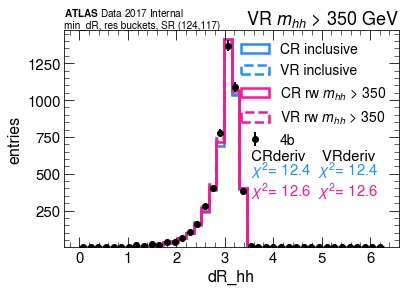

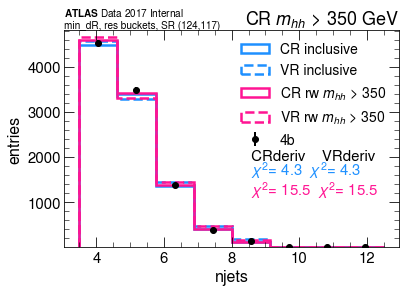

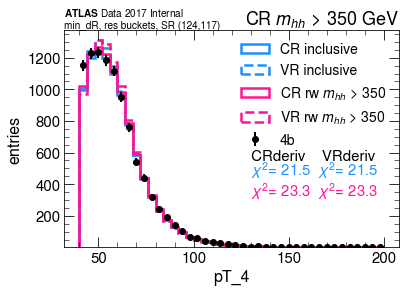

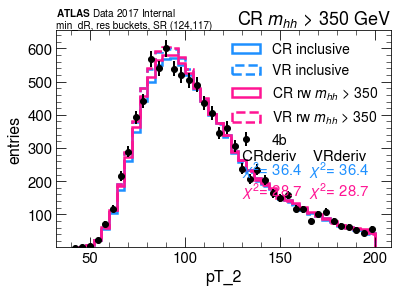

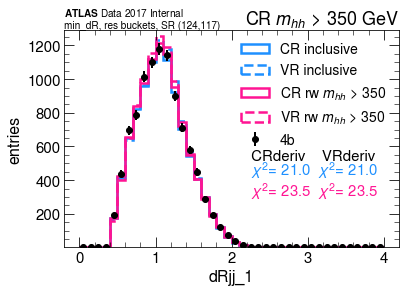

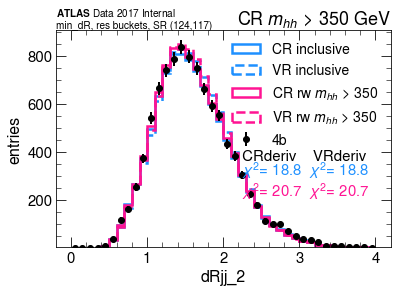

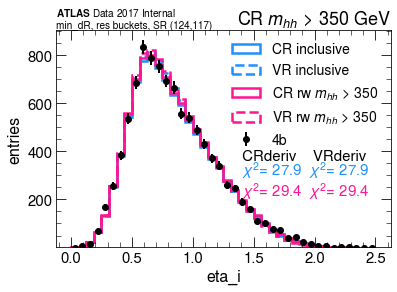

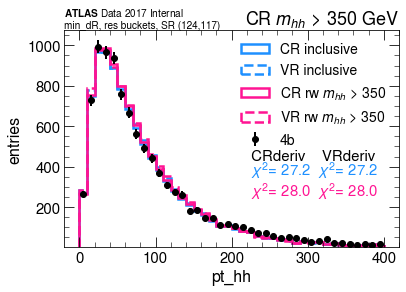

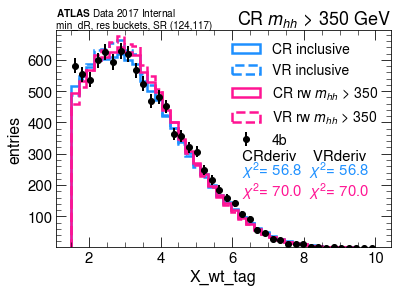

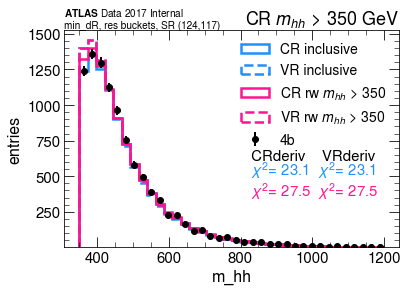

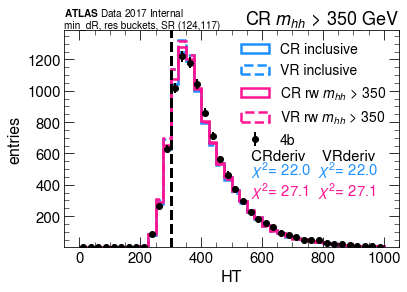

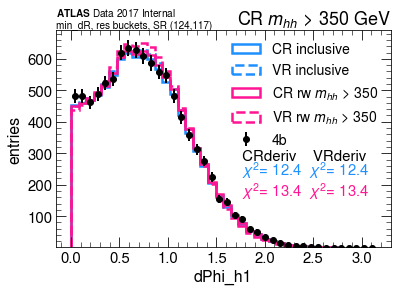

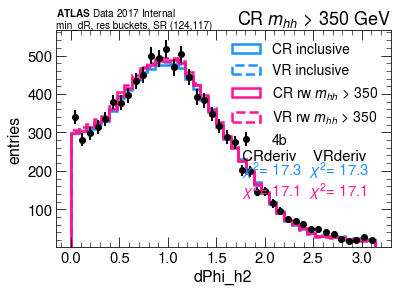

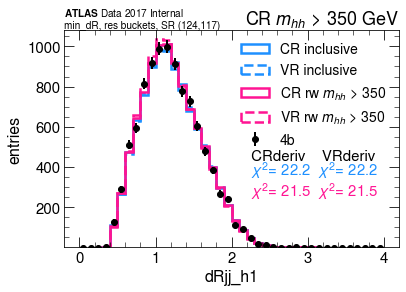

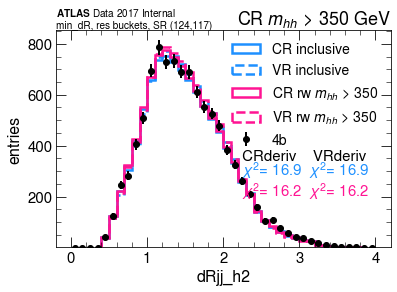

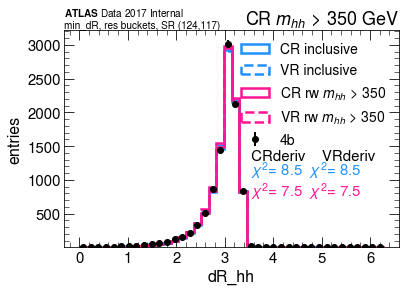

In [99]:
figDir = f'figures/data{yr}-JUN20/rw_m_hh_gt_350'
if not os.path.exists(figDir):
    os.mkdir(figDir)

ti =' $m_{hh}$ > 350 GeV'
colors = ['dodgerblue','deeppink']
for df,df_gt,region in zip([sr,vr,cr],[sr_gt,vr_gt,cr_gt],['SR','VR','CR']):

    mi = df.m_hh > 350
    
    #if region == 'SR': continue
    
    for c,n,r in zip(rw_cols,nBins,myRanges):

        if c == 'm_hh': 
            n = 36
            r = (350,1200)

            
        if region == 'SR':
            ls = []
            lc = colors
        else:
            ls = ['CRderiv    VRderiv']
            lc = ['k'] + colors

            
        plt.figure()
        # 4b  
        if region != 'SR':
            n_4b,e = np.histogram(df.loc[mi & (df.ntag>=4),c],n,r)

            xx = 0.5 * (e[1:]+e[:-1])
            plt.errorbar(xx, n_4b, np.sqrt(n_4b), color='k',label='4b',
                         marker='o',lw=0,elinewidth=2)
        
        # 2b trainings
        for dfi,color,l in zip([df,df_gt],colors,['inclusive','rw $m_{hh}$ > 350']):

            m_2b = mi & (df.ntag==2)
            
            n_2b_CR = plt.hist(df.loc[m_2b,c],n,r, label=f'CR {l}',
                               histtype='step',lw=2.5,color=color,ls='-',
                               weights=dfi.loc[m_2b,'w_2b'])[0]
            n_2b_VR = plt.hist(df.loc[m_2b,c],n,r, label=f'VR {l}',
                               histtype='step',lw=2.5,color=color,ls='--',
                               weights = dfi.loc[m_2b,'w_2b_VR'])[0]
                   
            err_CR = np.sqrt(np.histogram(df.loc[m_2b,c],n,r,
                                          weights=dfi.loc[m_2b,'w_2b']**2)[0])
            err_VR = np.sqrt(np.histogram(df.loc[m_2b,c],n,r,
                                          weights=dfi.loc[m_2b,'w_2b_VR']**2)[0])
                
            if region == 'SR':
                
                chi2 = weighted_chisquare(n_2b_CR,n_2b_VR,err_CR,err_VR,stat_lim=5)[0] / n
                ls.append(f'$\chi^2$ = {chi2:3.1f}')
                
                xloc = 0.25* r[0] + 0.75 *r[1]
                yloc = 0.45 * plt.ylim(1)[1]
                
            else:  
                
                zero = np.zeros_like(n_4b)
                chi_cr = weighted_chisquare(n_4b,n_2b_CR,zero,err_CR,stat_lim=5)[0] / n
                chi_vr = weighted_chisquare(n_4b,n_2b_VR,zero,err_VR,stat_lim=5)[0] / n
                ls.append(f'$\chi^2$={chi_cr: 3.1f}  $\chi^2$={chi_cr: 3.1f}')
        
                xloc = 0.45 * r[0] + 0.55 *r[1]
                yloc = 0.4 * plt.ylim(1)[1]
        
        
        plt.xlabel(c,fontsize=16)
        plt.ylabel('entries',fontsize=16)
        plt.legend(loc='best')

        ax = plt.gca()
        plt.title(f'{region}{ti}',loc='right')
        plt.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

        ylim = plt.ylim()
        if 'HT' in c: plt.plot([300]*2,ylim,'k--')
        plt.ylim(ylim)   

        rainbow_text(xloc,yloc,ls,lc,yoffset=1)
        
        plt.savefig(f'{figDir}/{c}_{region}.pdf',bbox_inches='tight')

#         break
#     break

**And now for the low $m_{hh}$ region**

../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (

../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))
../eda_tools/utilities.py:367: RuntimeWarning: divide by zero encountered in true_divide
  pi = (w1*W1 / (s1**2)) + (w2*W2/ (

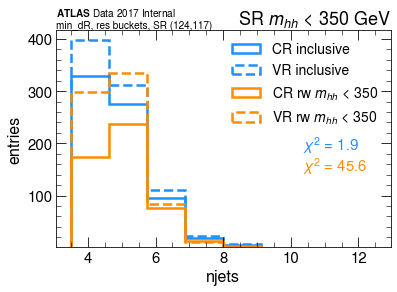

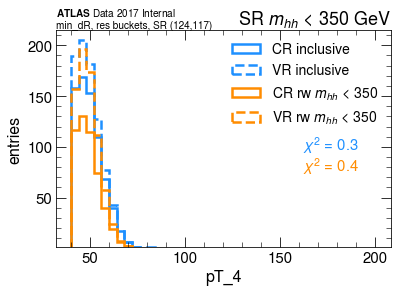

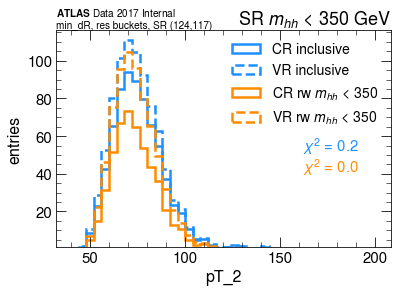

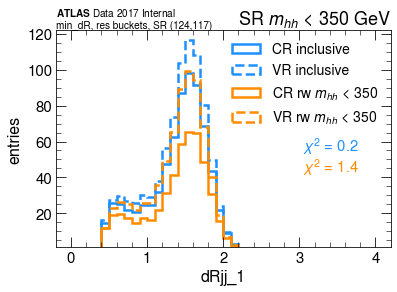

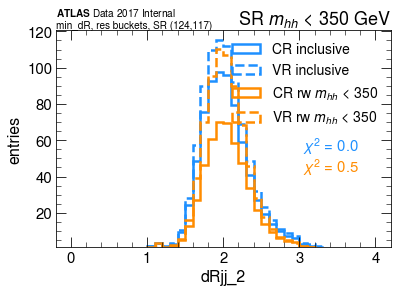

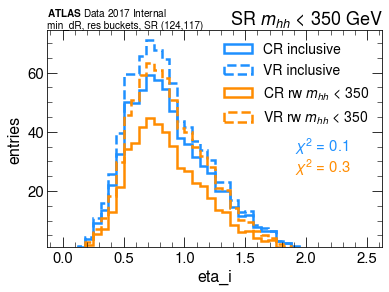

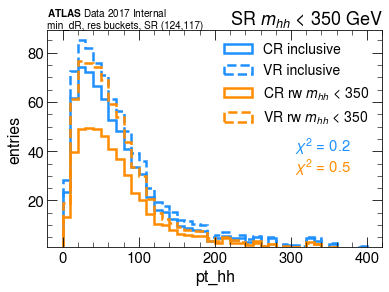

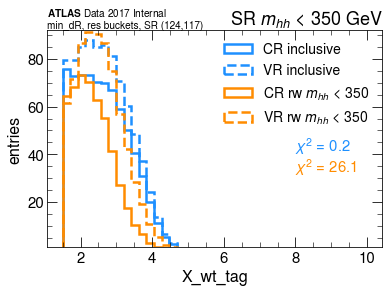

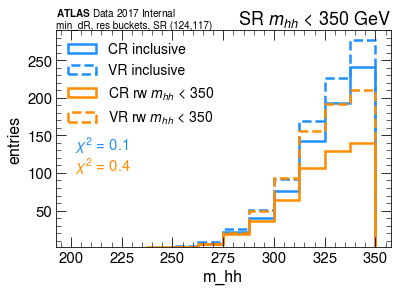

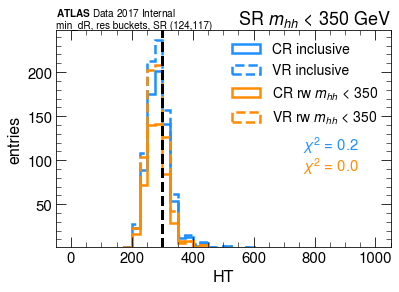

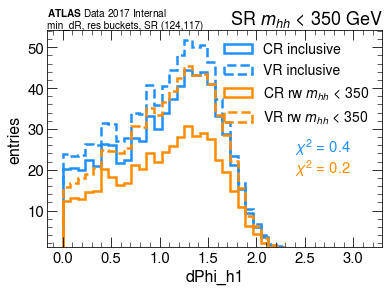

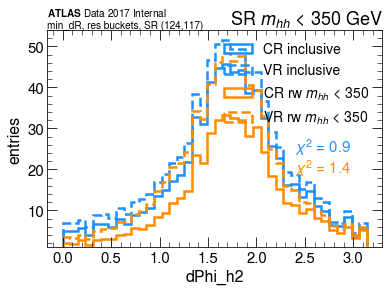

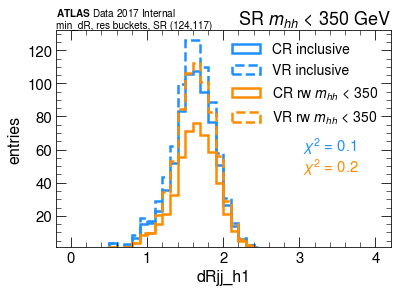

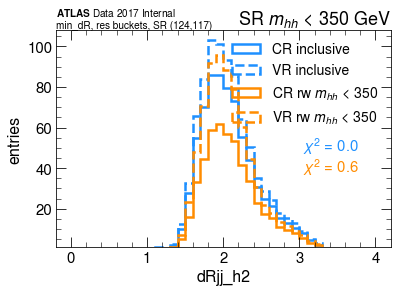

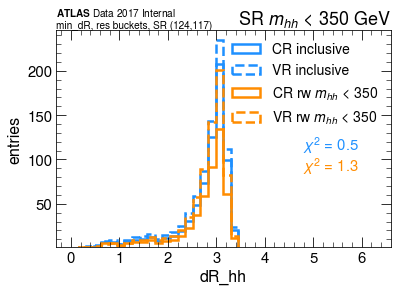

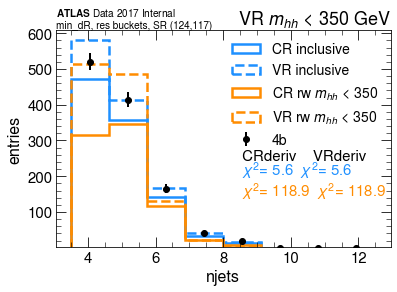

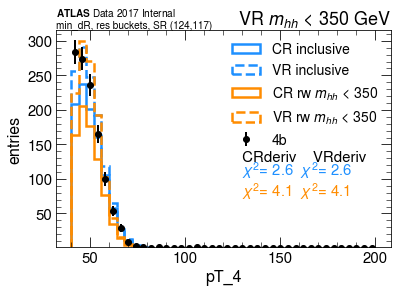

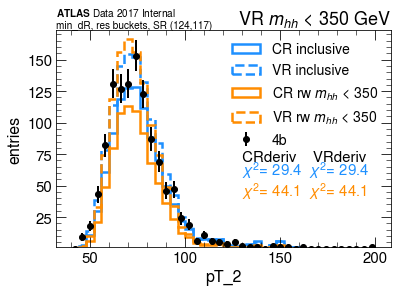

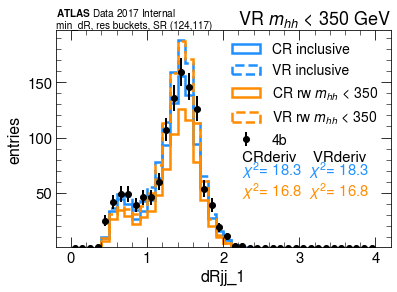

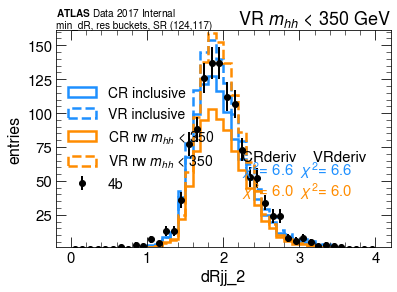

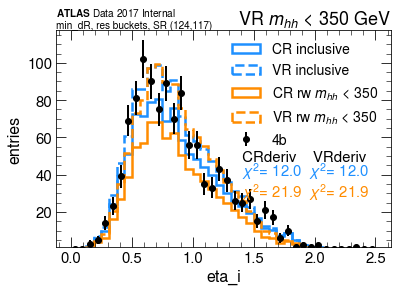

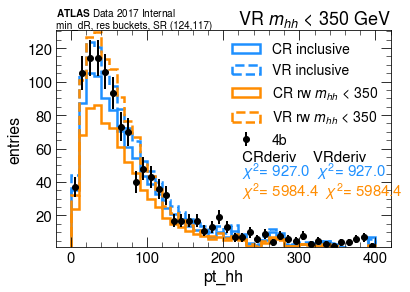

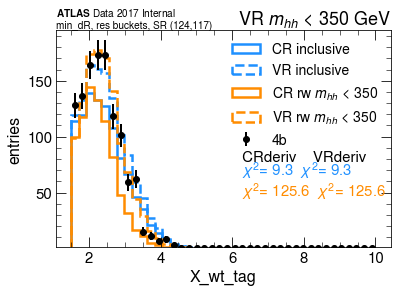

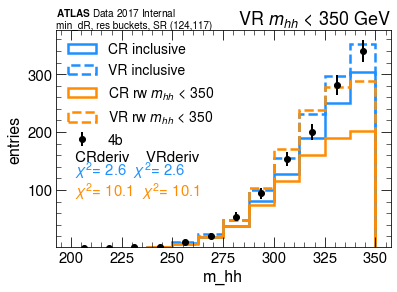

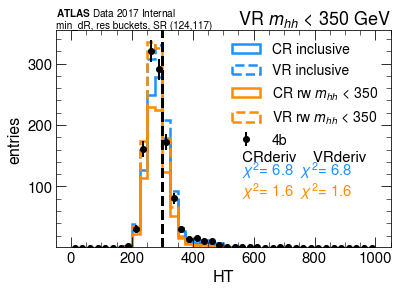

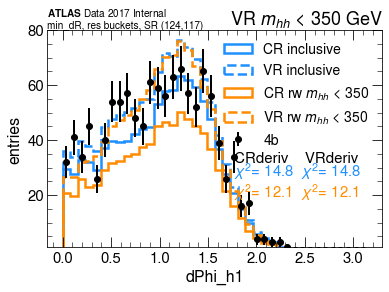

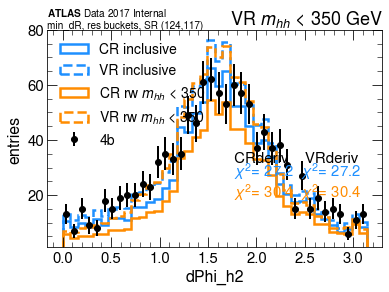

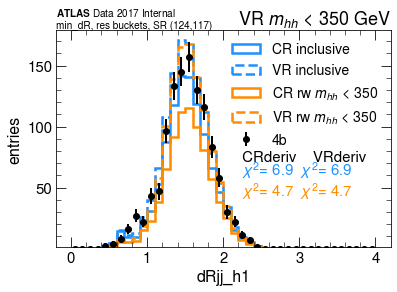

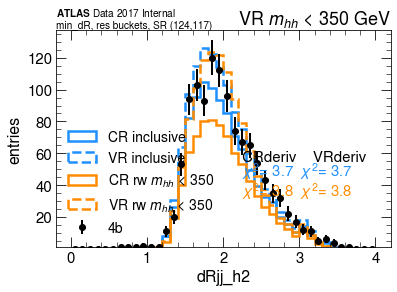

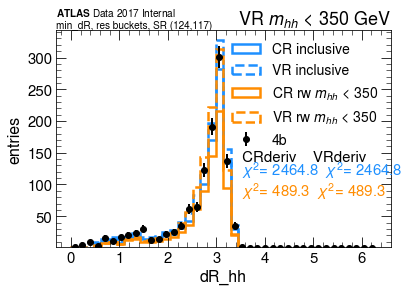

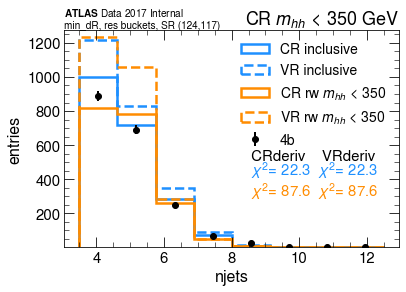

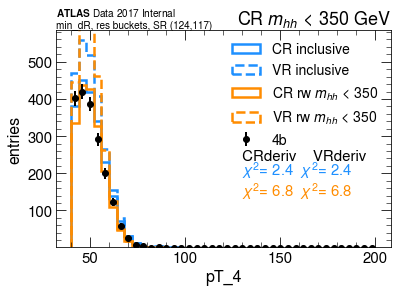

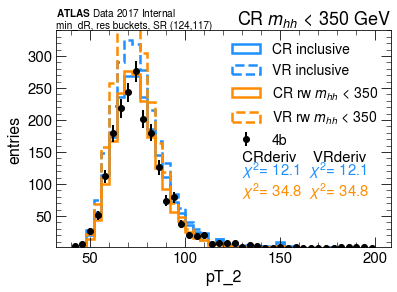

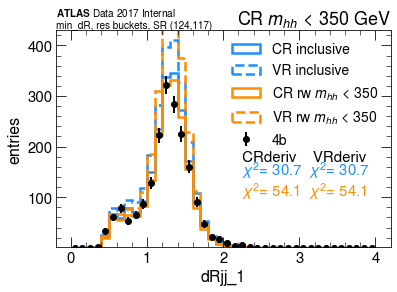

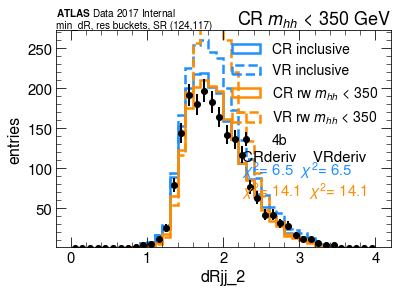

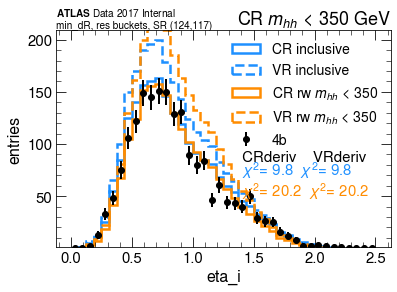

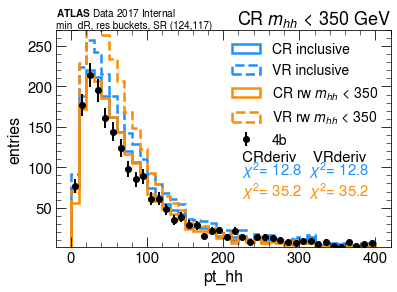

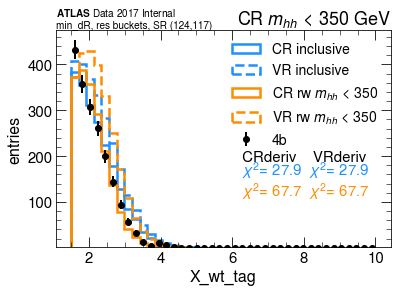

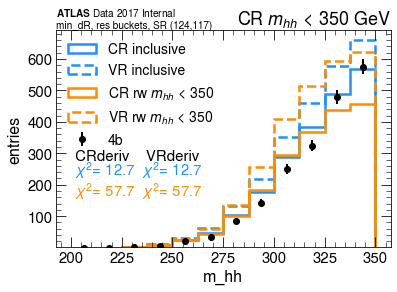

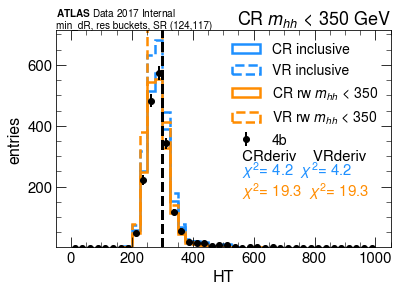

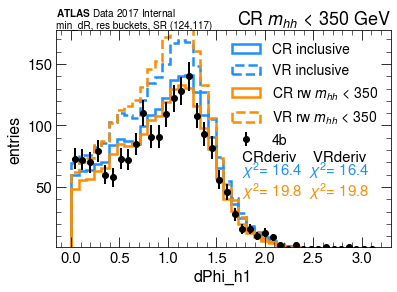

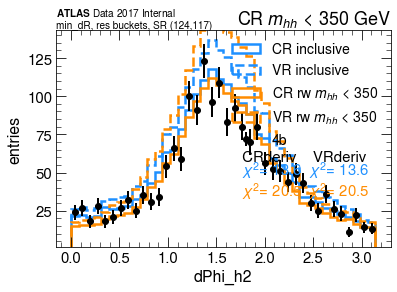

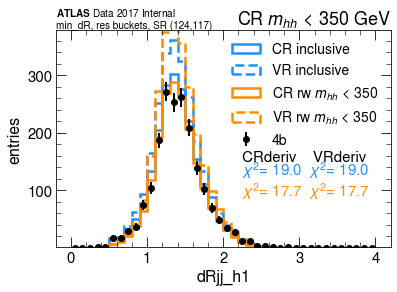

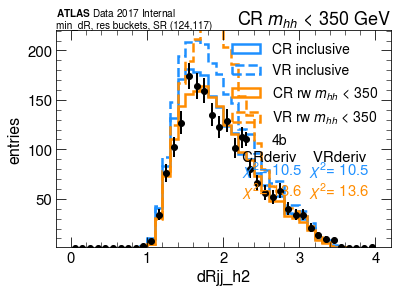

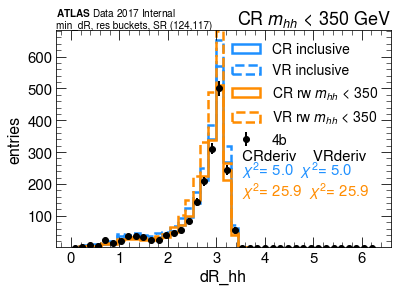

In [104]:
figDir = f'figures/data{yr}-JUN20/rw_m_hh_lt_350'
if not os.path.exists(figDir):
    os.mkdir(figDir)

ti =' $m_{hh}$ < 350 GeV'
colors = ['dodgerblue','darkorange']
for df,df_lt,region in zip([sr,vr,cr],[sr_lt,vr_lt,cr_lt],['SR','VR','CR']):

    mi = df.m_hh < 350
    
    for c,n,r in zip(rw_cols,nBins,myRanges):

        if c == 'm_hh': 
            n = 12
            r = (200,350)
            loc='upper left'
        else:
            loc='best'
            
        if region == 'SR':
            ls = []
            lc = colors
        else:
            ls = ['CRderiv    VRderiv']
            lc = ['k'] + colors

            
        plt.figure()
        # 4b  
        if region != 'SR':
            n_4b,e = np.histogram(df.loc[mi & (df.ntag>=4),c],n,r)

            xx = 0.5 * (e[1:]+e[:-1])
            plt.errorbar(xx, n_4b, np.sqrt(n_4b), color='k',label='4b',
                         marker='o',lw=0,elinewidth=2)
        
        # 2b trainings
        for dfi,color,l in zip([df,df_lt],colors,['inclusive','rw $m_{hh}$ < 350']):

            m_2b = mi & (df.ntag==2)
            
            n_2b_CR = plt.hist(df.loc[m_2b,c],n,r, label=f'CR {l}',
                               histtype='step',lw=2.5,color=color,ls='-',
                               weights=dfi.loc[m_2b,'w_2b'])[0]
            n_2b_VR = plt.hist(df.loc[m_2b,c],n,r, label=f'VR {l}',
                               histtype='step',lw=2.5,color=color,ls='--',
                               weights = dfi.loc[m_2b,'w_2b_VR'])[0]
                   
            err_CR = np.sqrt(np.histogram(df.loc[m_2b,c],n,r,
                                          weights=dfi.loc[m_2b,'w_2b']**2)[0])
            err_VR = np.sqrt(np.histogram(df.loc[m_2b,c],n,r,
                                          weights=dfi.loc[m_2b,'w_2b_VR']**2)[0])
                
            if region == 'SR':
                
                chi2 = weighted_chisquare(n_2b_CR,n_2b_VR,err_CR,err_VR,stat_lim=5)[0] / n
                ls.append(f'$\chi^2$ = {chi2:3.1f}')
                
                if c == 'm_hh':
                    xloc=r[0]
                else:
                    xloc = 0.25* r[0] + 0.75 *r[1]
                
                yloc = 0.45 * plt.ylim(1)[1]
                
            else:  
                
                zero = np.zeros_like(n_4b)
                chi_cr = weighted_chisquare(n_4b,n_2b_CR,zero,err_CR,stat_lim=5)[0] / n
                chi_vr = weighted_chisquare(n_4b,n_2b_VR,zero,err_VR,stat_lim=5)[0] / n
                ls.append(f'$\chi^2$={chi_cr: 3.1f}  $\chi^2$={chi_cr: 3.1f}')
        
                if c == 'm_hh':
                    xloc=r[0]
                else:
                    xloc = 0.45 * r[0] + 0.55 *r[1]
                yloc = 0.4 * plt.ylim(1)[1]
        
        
        plt.xlabel(c,fontsize=16)
        plt.ylabel('entries',fontsize=16)
        plt.legend(loc=loc)

        ax = plt.gca()
        plt.title(f'{region}{ti}',loc='right')
        plt.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

        ylim = plt.ylim()
        if 'HT' in c: plt.plot([300]*2,ylim,'k--')
        plt.ylim(ylim)   

        rainbow_text(xloc,yloc,ls,lc,yoffset=1)
        
        plt.savefig(f'{figDir}/{c}_{region}.pdf',bbox_inches='tight')

#         break
#     break

In [38]:
# df_ntag.to_hdf(f'{chi2Dir}/metrics.h5',key='df_ntag')
# df_pag.to_hdf(f'{chi2Dir}/metrics.h5',key='df_ntag_pag')

In [13]:
# chi2Dir = f'chi2s/{subDir}/{pconfig}/'
# if not os.path.exists(chi2Dir): 
#     print('Making new dir',chi2Dir)
#     os.mkdir(chi2Dir)

Making new dir chi2s/data17-JUN20-5jets_2b1jBucketBug/preLN_lr_0p003/


In [30]:
# index = [f'{r}{ti}' for ti,r in product([' $m_{hh}$ > 350 GeV',' $m_{hh}$ < 350 GeV',''],['CR','VR'])]

# df_ntag = pd.DataFrame(0,index,rw_cols)
# df_pag  = pd.DataFrame(0,index,rw_cols)

# df_ntag.columns.name = 'm_hh > 350'
# df_pag.columns.name  = 'm_hh < 350'

In [63]:
# df_ntag.round(1)